# **IRIS DATASET**

Marina Vallejo Vallés

Imports:

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px

import pymc3 as pm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
from scipy.stats import pearsonr

import networkx as nx

## **EDA**

The **iris** data set consists of 3 different types of irises (Setosa, Versicolour, and Virginica). There's information available about petals and sepals, stored in a 150x4 numpy.ndarray.

In order to work with this data, we must import it from sklearn library.

Checking the documentation we can see that there is a dictionary object containing the description of the data set. We are going to check it and obtain the official description of the data set.


In [ ]:
# Load data set
iris = load_iris()

# Check descr attribute
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In the previous chunk we can see the description of the Iris data set. There is information about its origin among others. But the important information for our analysis is that we have a total of **150 instances**, as we have 50 instances per class, with a total of **3 classes** (Setosa, Versicolour, Virginica). A class refers to the plant species, all from the *genus* Iris. We have **4 numeric attributes**, Petal/Sepal length and width, all measured in cm and we can see their summary statistics (Minimum value, Maximum value, Mean, Standard Deviation and Class Correlation). 

Note that there are no missing values, so it will not be necessary to perform data imputation.

In order to keep working with the data we convert it to a more suitable format, the data frame:

In [ ]:
# Convert it to data frame
df_iris = pd.DataFrame(iris.data, columns = iris.feature_names)

# Check part of the data frame
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Obtain distributions per attribute:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

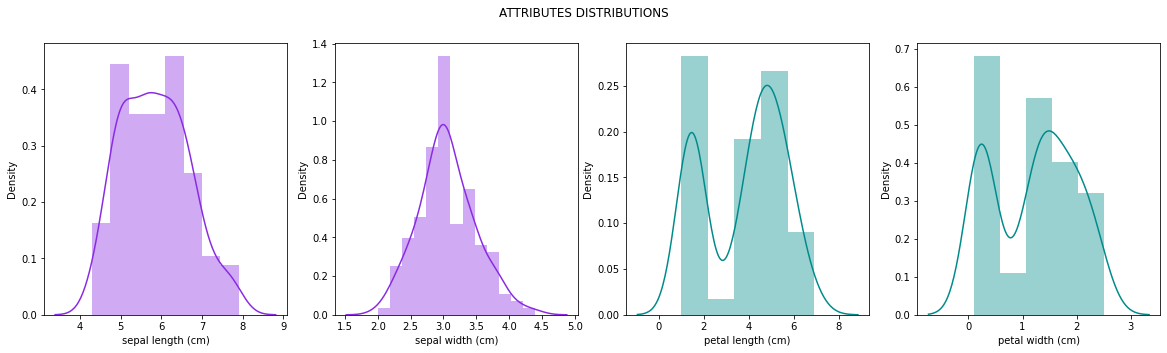

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
fig.suptitle('ATTRIBUTES DISTRIBUTIONS')
sns.distplot(df_iris['sepal length (cm)'], ax=axs[0], color='blueviolet')
sns.distplot(df_iris['sepal width (cm)'], ax=axs[1], color='blueviolet')
sns.distplot(df_iris['petal length (cm)'], ax=axs[2], color='darkcyan')
sns.distplot(df_iris['petal width (cm)'], ax=axs[3], color='darkcyan')

When you look at the distributions, you can see that there are two different distributions, normal and bimodal. Interestingly, the **sepal** attributes (length and width, purple color) follow a **normal distribution**, whereas the **petal** attributes (blue color) appear to follow a **bimodal distribution** since we can see two different bells. 

But if we check carefully the petal distributions, it looks like the bells in the right are wider than the bells in the left, for both plots, holding a bigger part of the measurements. Taking this into account, we will later consider the distribution of petal attributes as normal, in order to simplify the problem.

Get box plots per attribute:

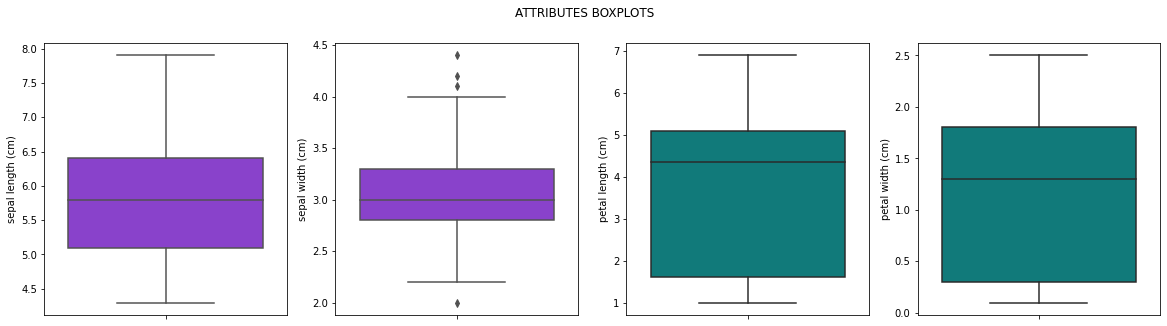

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
fig.suptitle('ATTRIBUTES BOXPLOTS')
sns.boxplot(data=df_iris, y='sepal length (cm)', ax=axs[0], color='blueviolet')
sns.boxplot(data=df_iris,y='sepal width (cm)', ax=axs[1], color='blueviolet')
sns.boxplot(data=df_iris,y='petal length (cm)', ax=axs[2], color='darkcyan')
sns.boxplot(data=df_iris,y='petal width (cm)', ax=axs[3], color='darkcyan')

In the previous box plots we can see that the only attribute with outliers is **Sepal Width**. It has a total of 4 outliers.  For the **petal** attributes we can see that the median is skewed to the upper quartile.

## **MODEL BUILDING**

With `pymc3`. Infer the parameters of the following models:

### **a) The mean and standard deviation of the distribution of one feature chosen by you, that we assume as normally distributed.**

For this part we will generate a model to infer the parameters from **petal length**.

As we have previously discussed, we will assume that **petal length** is following a **normal distribution**. We will generate a model to assess the mean $\mu$ and the standard deviation $\sigma$.

N( $\mu$ , $\sigma$)

Model building is a trial-error process. The following parameters and options have been selected after trying different approaches and evaluating the model.

One of the steps is to define the priors for the parameters to estimate in the model:

* For $\mu$ we choose the uniform distribution. This objective prior is non-informative, so the posterior will be very much determined by the data. As we are working with **petal length**, which cannot be negative, the lower limit will be set to 0. The upper limit will be set to 100 (after trying different options this is the one which has a better performance). 

* For $\sigma$ we choose the half normal distribution. As suggested in the literature, this prior distribution can be suitable for standard deviation on normal distributions.

Note that for `pm.sample()` (which allows to draw samples from the posterior using the given step methods), we don't specify the method. During the lectures we have been using **Metropolis** sampling method, but when used in this model, the performance was not adequate. By default `pymc3` will use **NUTS** step method if appropriate for the model.

Once we run the following chunk, it will return an object that contains the samples.

In [ ]:
with pm.Model() as model_petal_length:
  
  # Priors for the two parameters to estimate
  mu = pm.Uniform('mu', lower=0, upper=100)    # mean
  sigma = pm.HalfNormal('sigma', sd=10)     # standard deviation

  # The observed variable (assumed to be normally distributed)
  y = pm.Normal('y', mu=mu, sd=sigma, observed=df_iris['petal length (cm)'].values)

  # tune of 1000 samples, get 10000 posterior samples.
  trace_petal_length = pm.sample(10000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


Get a graphical representation of **model_petal_length**:

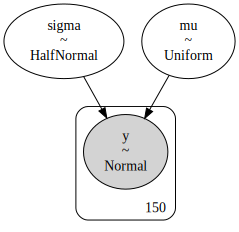

In [ ]:
pm.model_to_graphviz(model_petal_length)

Plot samples histograms and values:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67eb44b750>,
      dtype=object)

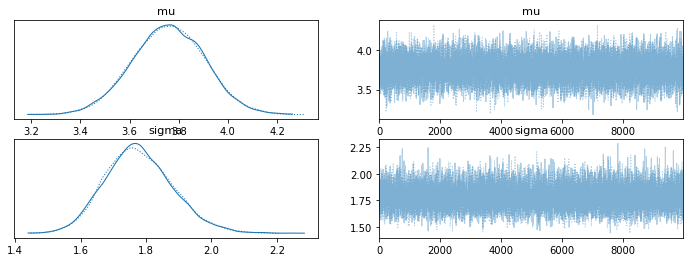

In [ ]:
pm.traceplot(trace_petal_length)

Checking the histograms we can see that parameters $\mu$ and $\sigma$ have converged. Both lines, solid and dashed, are almost identical with minor differences. We can say that the model successfully infers these parameters.

But lets keep exploring the model.

Plot Posterior densities:

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67eb11e650>,
      dtype=object)

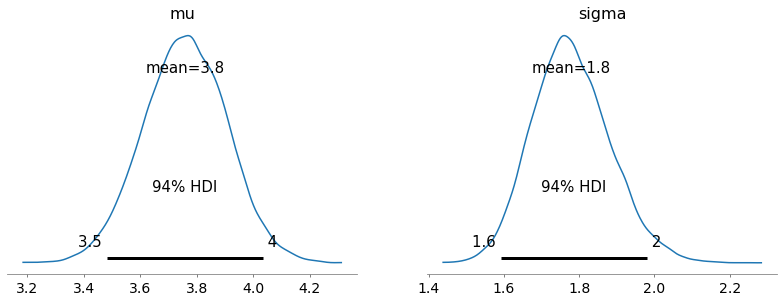

In [ ]:
pm.plot_posterior(trace_petal_length)

Checking the posterior distributions we can see represented by a black line the 94 % Highest Density Interval (HDI). 

HDI contains values that have some minimal level of posterior credibility. The total probability of all these values is 95%. 

For $\mu$ the interval is between 3.5 and 4.

For $\sigma$ the interval is between 1.6 and 2.


Now generate forest plot of 100*(1-alpha)% credible intervals for the set of variables in the model:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67eeec7810>],
      dtype=object)

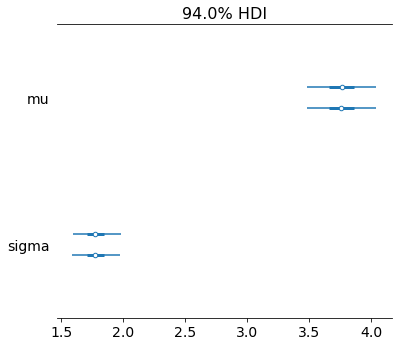

In [ ]:
pm.forestplot(trace_petal_length)

Bar plot of the autocorrelation function for a **trace_petal_length**:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67eb074690>,
      dtype=object)

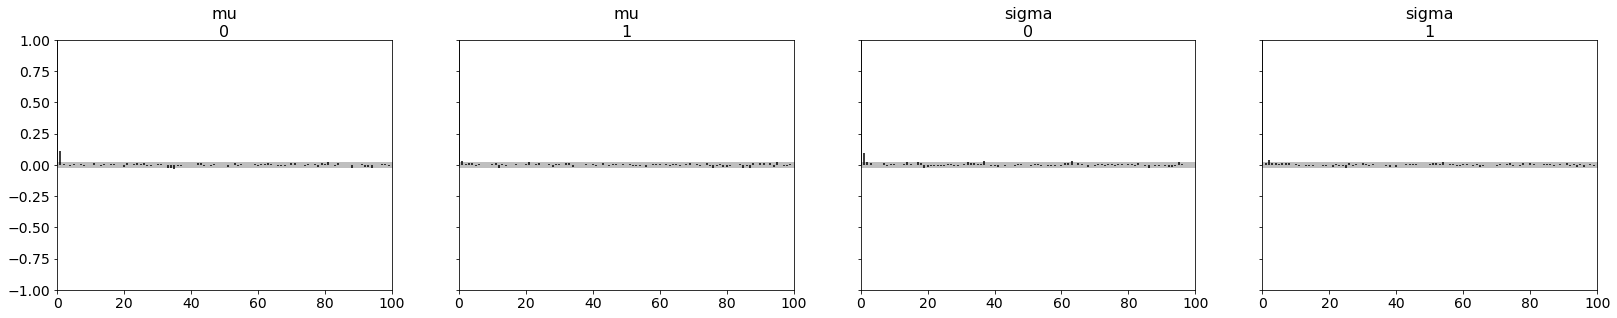

In [ ]:
pm.autocorrplot(trace_petal_length) 

Get an extended summary of the inferred parameters:

In [ ]:
pm.summary(trace_petal_length)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.759,0.148,3.482,4.035,0.001,0.001,17247.0,12912.0,1.0
sigma,1.779,0.104,1.592,1.979,0.001,0.001,16067.0,14498.0,1.0


In this table, we can see the estimated means for our parameters. 

* For $\mu$ we have an estimated mean of 3.759, and from the description of the data set we know that its real value is 3.76

* For $\sigma$ we have an estimated mean of 1.779, and from the description of the data set we know that its real value is 1.76 

The estimated values and the real ones are the same. Our model has successfully inferred these parameters. We can conclude that it is an appropriate model to infer the parameters for **petal length**.

As an extra, we will try the find_MAP function.

The difference with pm.sample() is that instead of giving the draws of the posterior distribution, find_MAP runs optimization and gives exactly one parameter set.

In [ ]:
MAP = pm.find_MAP(model=model_petal_length)

MAP

{'mu': array(3.75800047),
 'mu_interval__': array(-3.24297882),
 'sigma': array(1.7592231),
 'sigma_log__': array(0.56487229)}

### **b) The Petal Width as linear function of the other three features.**

Now we are going to work with a different model. Our objective here is to build a model that can predict **Petal Width** as a linear function of the other three features in the data set, which are: **Petal Length**, **Sepal Width** and **Sepal Length**.

The formula for `model_petal_width` :

$\mu = \alpha_1 * petallength + \alpha_2 * sepallength+  \alpha_3 * sepalwidth + \epsilon $

In this case, we will have to set 5 different priors: 3 alphas (one for each feature), 1 error factor ($\epsilon$) and the standard deviation ($\sigma$).

Note that for the standard deviation we follow the same approach as before, as we set a Half Normal distribution for the prior. For the rest parameters we will use a Normal distribution.

In [ ]:
with pm.Model() as model_petal_width:

  # Priors for the 5 parameters to estimate
  alpha = pm.Normal('alpha', mu=0, sigma=10, shape=3)
  epsilon = pm.Normal('epsilon', mu=0, sigma=10)
  sigma = pm.HalfNormal('sigma', sigma=1)

  # Expected value of outcome
  mu = alpha[0]*df_iris["sepal length (cm)"] + alpha[1]*df_iris["sepal width (cm)"] +  alpha[2]*df_iris["petal length (cm)"] + epsilon

  # The observed variable (assumed to be normally distributed)
  y = pm.Normal('y', mu=mu, sigma=sigma, observed=df_iris["petal width (cm)"])

  # tune of 1000 samples, get 10000 posterior samples.
  trace_petal_width = pm.sample(10000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, epsilon, alpha]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 163 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


Get a graphical representation of **model_petal_width**:

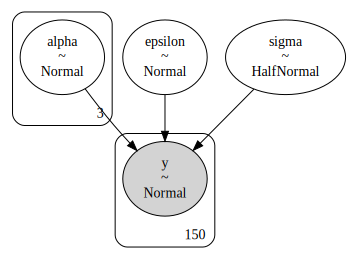

In [ ]:
pm.model_to_graphviz(model_petal_width)

Plot samples histograms and values:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67f87931d0>,
      dtype=object)

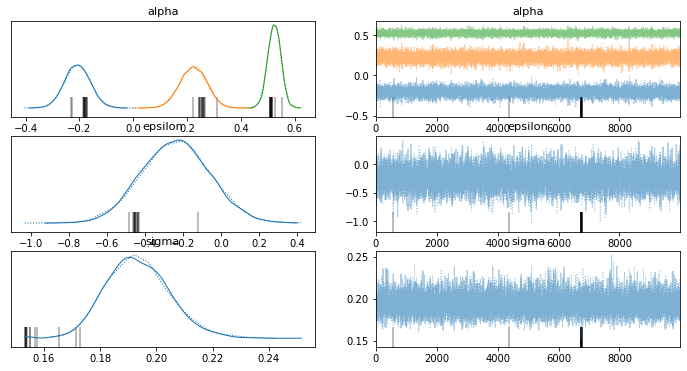

In [ ]:
pm.traceplot(trace_petal_width)

Checking the histograms we can see that parameters $\alpha$, $\epsilon$ and $\sigma$ have converged. For all the distributions, both lines, solid and dashed, are almost identical.

In the $\alpha$ plot we can see three different distributions, and all of them converged. Remember that we had three different $\alpha$, one related to each feature. 

The model seems appropriate to infer all of these parameters.

Plot Posterior densities:

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67eb22ef10>,
      dtype=object)

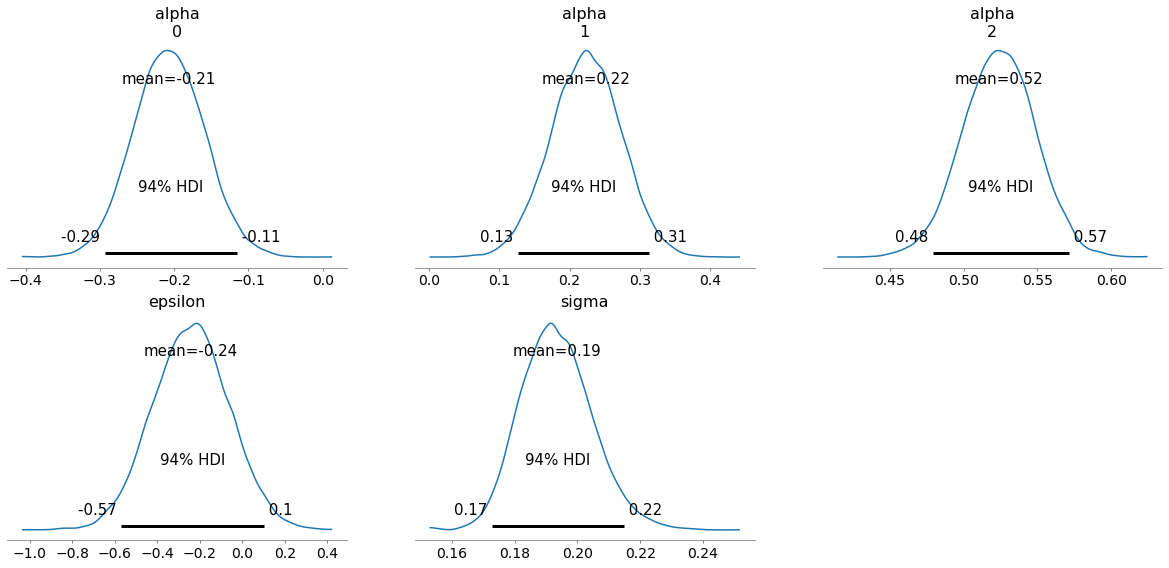

In [ ]:
pm.plot_posterior(trace_petal_width) 

Generate forest plot of 100*(1-alpha)% credible intervals for the set of variables in the model:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67e96356d0>],
      dtype=object)

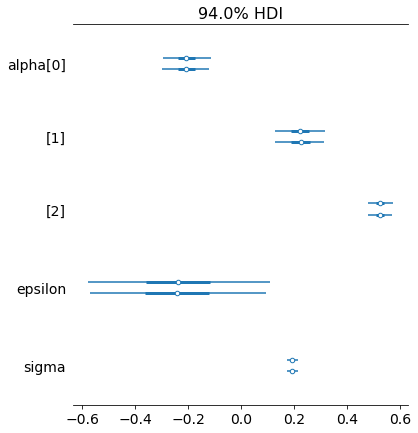

In [ ]:
pm.forestplot(trace_petal_width)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67e97f32d0>,
      dtype=object)

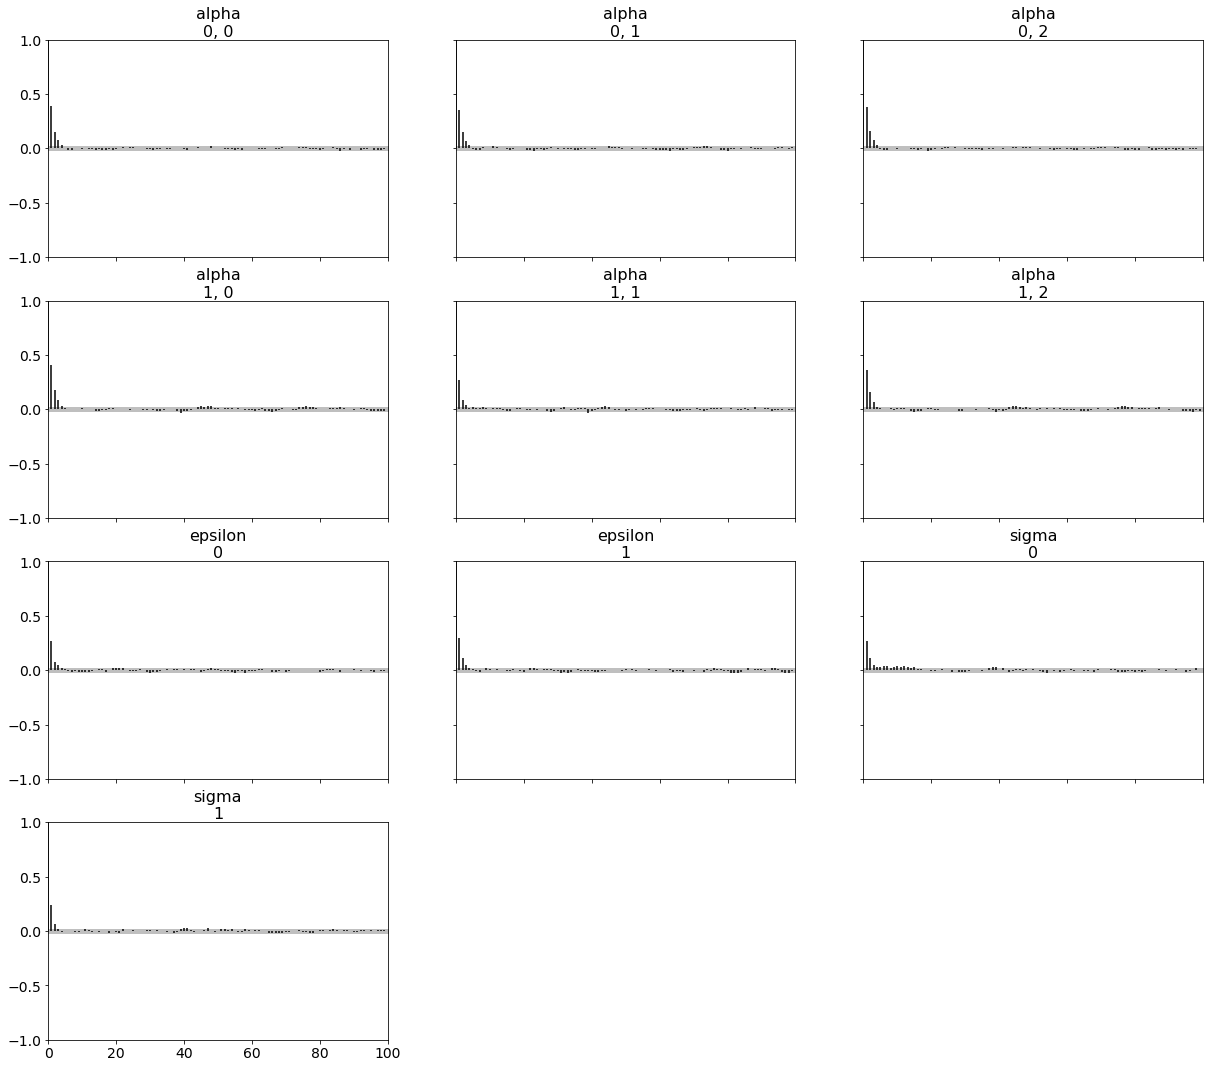

In [ ]:
pm.autocorrplot(trace_petal_width) # Bar plot of the autocorrelation function for a trace.

In [ ]:
pm.summary(trace_petal_width)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.207,0.048,-0.294,-0.115,0.001,0.000,8553.0,9290.0,1.0
alpha[1],0.223,0.050,0.127,0.314,0.001,0.000,9922.0,9910.0,1.0
alpha[2],0.524,0.025,0.479,0.572,0.000,0.000,8923.0,9314.0,1.0
epsilon,-0.241,0.180,-0.570,0.103,0.002,0.001,10540.0,10404.0,1.0
sigma,0.193,0.011,0.173,0.215,0.000,0.000,9904.0,7581.0,1.0


Build our equation with the inferred parameters:

$\mu = \alpha_1 * petallength + \alpha_2 * sepallength+  \alpha_3 * sepalwidth + \epsilon $

$\mu = -0.207 * petallength + 0.223 * sepallength  +  0.524	 * sepalwidth -0.241 $

**find_MAP** function:

In [ ]:
MAP2 = pm.find_MAP(model=model_petal_width)

MAP2

{'alpha': array([-0.20726557,  0.22280905,  0.52407952]),
 'epsilon': array(-0.24023624),
 'sigma': array(0.18937155),
 'sigma_log__': array(-1.66404433)}

## **CLUSTERING**

For this part, we will use **k-means** clustering method. In this method you must define the number of clusters `k` in your model. As we have three different types of irises (Setosa, Versicolour, and Virginica), we will set `k=3`. 

For the algorithm we select **full**, as it is the classical EM-style algorithm (although is more memory intensive, it works well with well-defined clusters). Note that we set a random state in order to be able to replicate the results.

In [ ]:
kmeans_iris = KMeans(n_clusters=3, algorithm = "full", random_state=1010)

Compute k-means clustering, no sample weight assigned (all observations are assigned equal weight):

In [ ]:
# pre-processing data to array-like, sparse matrix
matrix_iris = iris.data[:, :3]

# compute algorithm
kmeans_iris.fit(matrix_iris)

KMeans(algorithm='full', n_clusters=3, random_state=1010)

Check centers of each cluster:

In [ ]:
centers_iris = kmeans_iris.cluster_centers_
print(centers_iris)

[[5.006      3.428      1.462     ]
 [6.83571429 3.06428571 5.6547619 ]
 [5.84655172 2.73275862 4.3637931 ]]


Check the labels assigned by **k-means** and the **real labels**:

In [ ]:
labels_model = kmeans_iris.labels_
labels_real = iris.target
print(labels_model)
print(labels_real)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In order to know the relationship between real labels and iris species we checked the documentation: **'target_names': array(['setosa', 'versicolour', 'virginica']**

`0: setosa, 1: versicolour, 2: virginica`

We can see that for cluster **0**, the model predicts with a high accuracy. All the real labels 0 are tagged as 0 by the model. **k-means** successfully differentiates the samples belonging to **setosa** species. 

Whereas for labels **1** and **2** it seems to classify some samples from group 1 in group 2 and vice versa. **k-means** has lower accuracy when clustering samples belonging to **versicolour** and **virginica** species.

Now we must check the results with a graphical representation.

A 3D graphical representation would be useful to check the clusters, but as we have 4 different attributes, we must get rid of one of them. We choose the attributes arbitrary, and get rid of the **petal width** (as it's just for visual assessment of results).


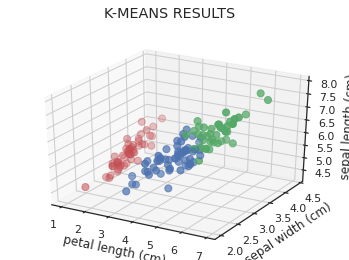

In [ ]:
# Generate 3d plot
sns.set(style = "ticks")

fig = plt.figure()
fig.suptitle('K-MEANS RESULTS')

ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("petal length (cm)")
ax.set_ylabel("sepal width (cm)")
ax.set_zlabel("sepal length (cm)")
colormap = np.array(['r', 'g', 'b'])
p = ax.scatter(matrix_iris[:,2], matrix_iris[:,1], matrix_iris[:,0], s=50, c=colormap[labels_model])

# legend = ax.legend(*p.legend_elements(), title="Clusters", borderaxespad=-1)
# ax.add_artist(legend)

plt.show()

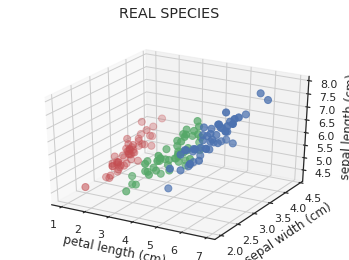

In [ ]:
labels_model = kmeans_iris.labels_
labels_real = iris.target

sns.set(style = "ticks")

fig = plt.figure()
fig.suptitle('REAL SPECIES')

ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("petal length (cm)")
ax.set_ylabel("sepal width (cm)")
ax.set_zlabel("sepal length (cm)")
colormap = np.array(['r', 'g', 'b'])
p = ax.scatter(matrix_iris[:,2], matrix_iris[:,1], matrix_iris[:,0], s=50, c=colormap[labels_real])

# legend = ax.legend(*p.legend_elements(), title="Clusters", borderaxespad=-1)
# ax.add_artist(legend)

plt.show()

Comparing the 3D plots, we can see that the **k-means** algorithm is able to clearly separate 3 groups that have a similar shape than the **real groups** seen in the iris data set (setosa-versicolour-virginica). But if we pay attention, the green and blue colors are shuffled, it is incorrectly assigning samples from **versicolor** to **virginica** and vice versa.

Now we are going to obtain quantitative results in order to properly assess the performance:

In [ ]:
print( " Confusion matrix:",  "\n", confusion_matrix(labels_real, labels_model, normalize="all"),  "\n")

print(" Classification report:", "\n", classification_report(labels_real, labels_model, target_names= iris.target_names))

 Confusion matrix: 
 [[0.33333333 0.         0.        ]
 [0.         0.03333333 0.3       ]
 [0.         0.24666667 0.08666667]] 

 Classification report: 
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.12      0.10      0.11        50
   virginica       0.22      0.26      0.24        50

    accuracy                           0.45       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.45      0.45      0.45       150



If we look at the **Confusion Matrix**, we can conclude that all the samples in the data set belonging to the **setosa** species have been correctly classified, a total of 33 % of samples. For the **versicolor** species we have bad results, from a total of 33 % only 3 % have been assigned to the correct group, while the rest have been assigned to the **virginica** species. We can see similar results for the **virginica** species, were from a total of 33 % only 8.7 % have been correctly clustered, while the rest where assigned to the **versicolor** species.

The **k-means** algorithm is not able to properly classify samples belonging to **versicolor** and **virginica**, with a precision of 0.12 and 0.22 for each group.

## **CLASSIFICATION**

Here we will use the **Random Forest Classifier** from scikit-learn. Before starting we must split the iris data set into 2 different groups, the training set and the test set.

The **test set** will be **33 %** of the original data, as recommended in literature.

In [ ]:
# Obtain features and labels:
features_iris = df_iris
labels_iris = iris.target

# Split iris data set
feat_train, feat_test, lab_train, lab_test = train_test_split(features_iris, labels_iris, test_size=0.33, random_state=1011) 

# Check one sub set to see if it's working
print(feat_train, "\n")

# Check number of instances in each sub set
print("Feature training:", len(feat_train))
print("Feature test:", len(feat_test))
print("Label training:", len(lab_train))
print("Label test:", len(lab_test))

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
58                 6.6               2.9                4.6               1.3
7                  5.0               3.4                1.5               0.2
118                7.7               2.6                6.9               2.3
44                 5.1               3.8                1.9               0.4
131                7.9               3.8                6.4               2.0
..                 ...               ...                ...               ...
141                6.9               3.1                5.1               2.3
45                 4.8               3.0                1.4               0.3
52                 6.9               3.1                4.9               1.5
78                 6.0               2.9                4.5               1.5
139                6.9               3.1                5.4               2.1

[100 rows x 4 columns] 

Feature training: 100
Feature test: 50

Once we have the splitted data sets, we have to generate the **Random Forest Classifier**, which will contain 15000 trees (`n_estimators`).

In [ ]:
# Create a Random Forest Classifier 
rf_iris =RandomForestClassifier(n_estimators=15000, verbose = 1, random_state = 1111)

# Train the model:
rf_iris.fit(feat_train,lab_train)

# Prediction:
y_pred=rf_iris.predict(feat_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 15000 out of 15000 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 15000 out of 15000 | elapsed:    2.8s finished


In [ ]:
# Check accuracy of model
print("Random Forest Classifier Accuracy:", accuracy_score(lab_test, y_pred))

Random Forest Classifier Accuracy: 0.96


In [ ]:
print( " Confusion matrix:",  "\n", confusion_matrix(lab_test, y_pred, normalize="all"),  "\n")

print(" Classification report:", "\n", classification_report(lab_test, y_pred, target_names= iris.target_names))

 Confusion matrix: 
 [[0.4  0.   0.  ]
 [0.   0.28 0.02]
 [0.   0.02 0.28]] 

 Classification report: 
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



The accuracy of the classifier is 0.96. It could be improved if we increased the number of trees. But as it is a high accuracy, maybe the computational cost of setting a Random Forest with many trees is not worth it. A very important part of model building is assessing the problem of the computational cost and the benefits and disadvantages of increasing the model complexity.

If we look at the detailed results in the **Confusion Matrix**, this classifier solves the problem seen before with **k-means**. It is able to properly classify **versicolor** and **virginica** species, only mixing a small percentage of the samples.

The algorithm has a precision of 1 for setosa species, and 0.93 for versicolor and virginica.

Overall we can conclude that the **Random Forest Classifier** has a better performance than **k-means**, and it is a suitable method to classify species from the Iris data set.

## **CORRELATION**

In order to analyze the relationship between each pair of features we are going to perform a correlation and then plot it using a heatmap.

The correlation function allows to find the pairwise correlation of the different columns of a given data frame. The default method used is **Pearson** and it returns the standard correlation coefficient.

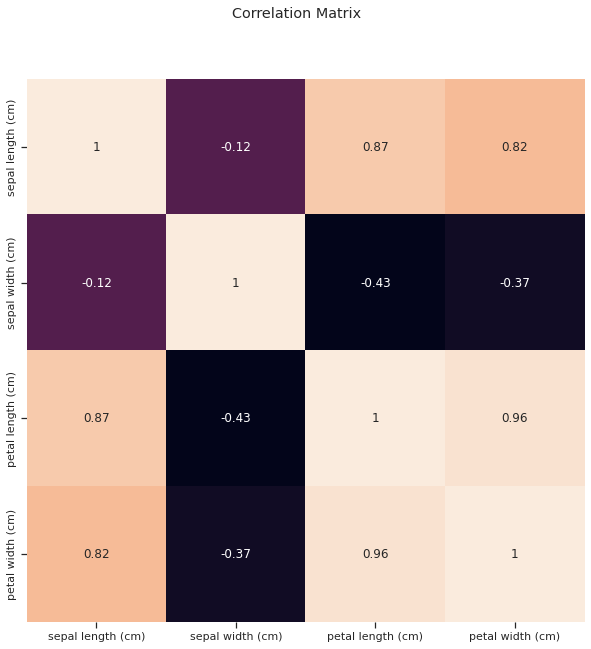

In [ ]:
# Calculate correlation
correlation_iris = df_iris.corr()

# Plot correlation
fig, axs = plt.subplots(figsize=(10,10))
fig.suptitle('Correlation Matrix')
sns.heatmap(correlation_iris, annot=True, linecolor ="white", cbar = 0)

As a result we have obtained a symmetrical matrix. 

Checking this matrix we can say that **Sepal Length**-**Sepal Width** seem to be independent, as their correlation value is close to 0. Interestingly, **Petal Width**-**Petal Length** have a high correlation value, close to 1, we can say that they are highly positively correlated. This polarity of results is quite interesting, as Sepal attributes seem to be independent one to the other but then Petal attributes can be thought to be dependent.

We can draw the same conclusion for **Petal Length**-**Sepal Length** as well as **Petal Width**-**Sepal Length**, we can think that they are dependent.

For the two pairs left, **Petal Length**-**Sepal Width** and **Petal Width**-**Sepal Width** seem to be poorly negatively correlated. We can think that they are independent.

**Sepal Width** seeems to be independent to the rest of variables, as all the pairs where it is involved, have correlation coefficients closer to 0.

## **CAUSAL MODEL**

if we assign the following numerical values: Setosa=0, Versicolour=1, and Virginica=2 and we propose the following causal model:
`Sepal Length -> Sepal Width -> Plant Type <- Petal Width <- Petal Length`







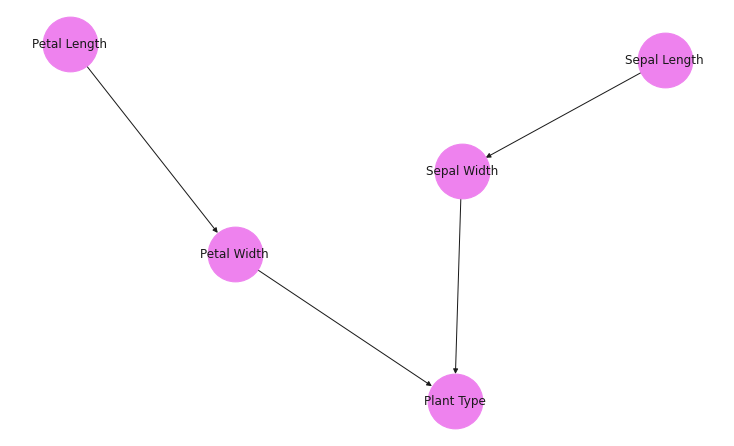

In [ ]:
G = nx.DiGraph()
G.add_edges_from([('Sepal Length', 'Sepal Width'), ('Sepal Width', 'Plant Type'), ('Petal Width', 'Plant Type'), ('Petal Length', 'Petal Width')], node_color='red')

pos = nx.spring_layout(G, seed=111)
plt.figure(figsize=(10,6))
nx.draw(G, with_labels=True, pos=pos,node_size = 3000, node_color = 'violet')

### **a) Which relation of independence we should expect between Sepal Length and Petal Length? Check it.**

In order to assess the independence we need to determine the **Basis Set**:

* First of all we must list all the unique pairs of **non-adjacent variables**.

`{("Petal Length", "Plant Type"),("Petal Length", "Sepal Width"),("Petal Length", "Sepal Length"), ("Petal Width", "Sepal Width"),("Petal Width", "Sepal Length"), ("Plant Type", "Sepal Length")}`

* For each pair, find the causal parents.

* Build the D-Separation statement

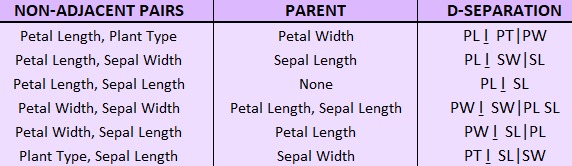

As Sepal Length and Petal Length have no causal parents, they have to be **unconditional independent**. 

Now we will check it:

Text(0, 0.5, 'petal length (cm)')

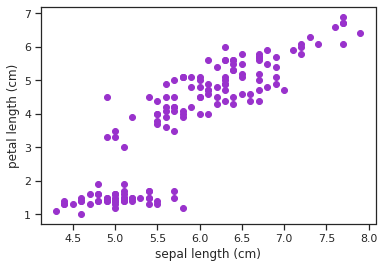

In [ ]:
plt.scatter(df_iris["sepal length (cm)"], df_iris["petal length (cm)"], color="darkorchid")
plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")

In [ ]:
r, p = pearsonr(df_iris["sepal length (cm)"], df_iris["petal length (cm)"])
print(" r:",r,"\n","p-value:",p)

 r: 0.8717537758865831 
 p: 1.0386674194498099e-47


Although we previously found that **Sepal Length** and **Petal Length** should be independent after defining the basis set, the Pearson correlation results show the opposite (the obtained p-value is lower than 0.05). Our previous hypothesis is not supported by the data.

### **b) And if we condition on Plant type?**

Conditioning means to introduce specific information about a certain variable in our model.

In order to find the relation of independence between **Sepal Length** and **Petal Length** conditioning in **Plant type** we must follow a different approach than before.

**Plant type** is a **collider**, it is a vertex with arrows pointing into it from both directions. We also know that it is an **unshielded collider**, the variables pointing into it are not adjacent. There is only one possible path between the two variables that we want to test their relationship, and as the path has this collider, we say that it is blocked. The natural state of a collider is to be inactive, it can be considered as a switch that in a normal state is off and doesn't transfer causality. 

The idea is that if we condition in **Plant Type**, as it is a **collider** we activate it and we will obtain an opposite causal effect. In other words, if **Sepal Length** and **Petal Length** are expected to be independent, now conditioning in **Plant type** they will be dependent.




*   Without conditioning on Plant Type

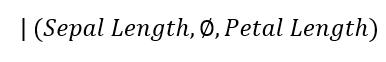

*   Conditioning on Plant Type

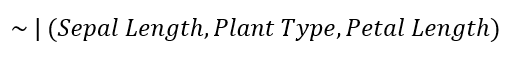

### **c) And if we condition on Petal Width?**

**Petal With** is a **non-collider**, it is a variable that is not  influenced by two other variables. 

If we condition on a non-collider, it will change to inactive state. This means that the causal path will change to blocked and then **Petal Length** and **Sepal Length** will be independent.